In [22]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
import copy
%matplotlib inline
print 'success'

success


In [23]:
# generate training data set
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1
num_samples = 30000

X = np.zeros(num_samples)
for i in xrange(num_samples):
    u = np.random.random()
    if (u<0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))

# visualize the data
# plt.figure()
# plt.hist(X, bins = 10)
print 'success'

success


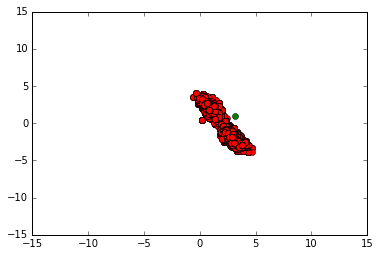

In [24]:
# do the training to estimate \theta value random walk proposer
def random_walk_proposer(theta1_t, theta2_t, sigmaraw1_sq, sigmaraw2_sq):
    u1 = np.random.normal(0, sigmaraw1_sq)
    u2 = np.random.normal(0, sigmaraw2_sq)
    theta1_new = theta1_t + u1
    theta2_new = theta2_t + u2
    return (theta1_new, theta2_new)

def ll_theta(theta1, theta_2, sigma1, sigma2):
    den1 = sigma1*sqrt(2*pi)
    den2 = sigma2*sqrt(2*pi)
    exp1 = exp(-1*(theta1)**2/(2*sigma1**2))
    exp2 = exp(-1*(theta2)**2/(2*sigma2**2))
    ll = exp1/den1 * exp2/den2
    return ll
    
def eval_U0(N, theta1_t, theta2_t, theta1_new, theta2_new, sigma1, sigma2):
    u = np.random.random()
    rho_theta_t = ll_theta(theta1_t, theta2_t, sigma1, sigma2)
    rho_theta_new = ll_theta(theta1_new, theta2_new, sigma1, sigma2)
    U0 = 1/N * log( u * rho_theta_t / rho_theta_new )
    return U0

def ll_data(x, theta_t, theta_new, sigmax):
    # for theta_t
    ll_x_theta_t1=0.5*exp(-1*(x-theta_t[0])**2/(2*sigmax**2))/(sigmax*sqrt(2*pi))
    ll_x_theta_t2=0.5*exp(-1*(x-theta_t[0]-theta_t[1])**2/(2*sigmax**2))/(sigmax*sqrt(2*pi))
    ll_x_theta_t = ll_x_theta_t1 + ll_x_theta_t2
    
    # for theta_new
    ll_x_theta_n1=0.5*exp(-1*(x-theta_new[0])**2/(2*sigmax**2))/(sigmax*sqrt(2*pi))
    ll_x_theta_n2=0.5*exp(-1*(x-theta_new[0]-theta_new[1])**2/(2*sigmax**2))/(sigmax*sqrt(2*pi))
    ll_x_theta_n = ll_x_theta_n1 + ll_x_theta_n2
    
    res = ll_x_theta_n/ll_x_theta_t
    if res ==0 :
        return log(0.0000000000001)
    else:
        return log(res)

def make_decision(l_value,N, U0):
    n = float(len(l_value))
    l_mean = sum(l_value)/n
    l_square = map(lambda x: x ** 2, l_value)
    l_square_mean = sum( l_square) / n
    sl = sqrt( n/(n-1) * (l_square_mean - l_mean**2) )
    s = sl/sqrt(n) * sqrt(1 - (n-1)/(N-1) )
    
    if s == 0: 
        delta = 0
    else:
        t_stats = abs( (l_mean - U0)/s )
        delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
def generate_theta(N, theta_t, sigma_theta, sigmax, X, epsilon, sigmaraw1_sq, sigmaraw2_sq):
    # generate potential new theta value
    theta_new = random_walk_proposer(theta_t[0], theta_t[1], sigmaraw1_sq, sigmaraw2_sq)
    
    # compute U0
    U0 = eval_U0(N, theta_t[0], theta_t[1], theta_new[0], theta_new[1], sigma_theta[0], sigma_theta[1])
    
    # take new data points to calculate new delta value
    m = 10
    l_value = []
    for i in range(0,m):
        mid = ll_data(X[i], theta_t, theta_new, sigmax)
        l_value.append(mid)
    
    # make decision
    delta = make_decision(l_value, N, U0)
    while (delta > epsilon) and (m < N-10) :
        for i in range(m,m+10):
            mid = ll_data(X[m], theta_t, theta_new, sigmax)
            l_value.append(mid)
        m = m + 10
        delta = make_decision(l_value, N, U0)
    
    l_mean = sum(l_value) / float(len(l_value))
    if (l_mean > U0):
        return theta_new
    else:
        return theta_t

def train(X, sigma_theta, sigmax, sigmaraw1_sq, sigmaraw2_sq):
    theta1_start = np.random.random()
    theta2_start = np.random.random()
    theta_t = [theta1_start, theta2_start]
    theta1_list = [theta1_start]
    theta2_list = [theta2_start]
    epsilon = 0.05
    for iter in range(100000):
        res = generate_theta(len(X), theta_t, sigma_theta, sigmax, X, epsilon,sigmaraw1_sq, sigmaraw2_sq)
        theta1_list.append(res[0])
        theta2_list.append(res[1])
        theta_t = copy.deepcopy(res)
    
    return (theta1_list, theta2_list)

# train
sigma_theta = [sqrt(sigma1_sq), sqrt(sigma2_sq)]
sigmax = sqrt(sigmax_sq)
sigmaraw1_sq = 4
sigmaraw2_sq = 1
(sigma1_list, sigma2_list) = train(X, sigma_theta, sigmax,sigmaraw1_sq, sigmaraw2_sq)

# plot
plt.figure()
plt.plot(sigma1_list, sigma2_list,'ro') # estimated value
plt.hold(True)
plt.plot(sqrt(sigma1_sq), sqrt(sigma2_sq), 'go') # ground truth value
plt.axis([-15, 15, -15, 15])
plt.show()